# **Table of Contents**
1. Useful functions
2. Libraries importing
3. Data preprossessing
4. Exploratory Data Analysis
5. Feature Engineering
6. Save data, clear all notebook load data.
7. Hypeparameter tuning
8. Final training 
9. Prediction + submission

Notebook pipeline
* I'll be leaving all functions on top of notebook. I would leave in a separate script, but its a notebook.
* Routine data loading and exploration.
* Preprocessing data to explore.
* EDA.
* Feature creation based on id's, mean encoding and trend treatment.
* I'll implement lgbm tuned by optuna for a better score.
* CV strategy will be a time series split (inside optuna objetive)
* Using best parameters, train a model, predict and submit.

# **Useful Functions**

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gc
import re
from sklearn.preprocessing import LabelEncoder
from itertools import product
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Reading Data**

In [ ]:
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')

In [ ]:
print('items')
print(items.head());
print('categories')
print(categories.head());
print('sales')
print(sales.head());
print('shops')
print(shops.head());
print('test')
print(test.head());

In [ ]:
print('Items')
print(items.shape);
print('categories')
print(categories.shape);
print('sales_train')
print(sales.shape);
print('shops')
print(shops.shape);
print('test')
print(test.shape);

In [ ]:
#First of all, I wish to merge all interesting data on a single DF.
sales.head()

In [ ]:
print ('Number of unique values in each column')
sales.nunique()

In [ ]:
#Defining date as datetime
sales['date'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y')

#Now for a month and year feature. (I find it useful for this kind of data to be grouped by for store, month and year for EDA)
sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year
#Feature for day of the week
sales['day_of_week'] = sales['date'].dt.day_of_week

#Making a revenue feature
sales['revenue'] = sales.item_price.values * sales.item_cnt_day.values
sales.head()

In [ ]:
sales = reduce_mem_usage(sales, verbose = True)
sales.info()

## **Exploratory Data Analysis**

First things first, I wanna be sure if all entries corresponds to exactly all days and months in years presented.

In [ ]:
print('Entries by year-month')
sales.groupby(['year', 'month'])['date'].nunique()

As we can see, in 2015, november and december are missing, we have to predict aggregated sum of cnt_item for november in this competition.

Now let's aggregate dataset to look at stores performance by year month in revenue

In [ ]:
sales_agg = sales.groupby(['year', 'month', 'shop_id'])['revenue'].sum().reset_index()
sales_agg['shop_id'].value_counts()

One thing interesting to note is that some shops don't have data for more than a year.

In [ ]:
sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(50, 50))

for i, j in enumerate(test.sort_values('shop_id').shop_id.unique()):
    temp = sales_agg[sales_agg['shop_id'] == j]
    fig = plt.subplot(10, 5, i+1)
    sns.lineplot(
        x = 'month',
        y = 'revenue',
        style = "shop_id",
        hue = 'year',
        ci = None,
        data = temp).set_xlim(1,12)

Well, it's definitively some messy time series data.
* First: some stores didn't exist, in 2013, so there is a lot of missing values.
* Second: somes stores closed in those 3 years interval.
* Third: as it is aggregated data, we can't say much about some specific items, but there are probably new items that started being sold and old items that got out of store. We can expect a lot of missing data such as 0 values in cnt column.


# Outlier treating
There are some outliers that need treatment.

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)

In [ ]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<1001]

Let's see if there are days with price < 0

In [ ]:
sales[sales.item_price < 0]

There is, I'll fill it with median.

In [ ]:
median = np.median(sales[sales['item_id'] == 2973].item_price.values)
sales.loc[sales['item_price'] < 0, 'item_price'] = median
any(sales['item_price'] < 0)

There is alse some duplicated shop names, change it for test and train

In [ ]:
# Якутск Орджоникидзе, 56
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In raw dataset, we can clearly see the time effect on sales. Also, how we should focus on creating relevant information about prices on time, and treat them for seasonality.

# **Data preprossessing**
I'll create a matrix with every possible combination on our hierarchy (item x shop by month) in order to provide a training set similar to test set.

In [ ]:
dataset = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    temp = sales[sales.date_block_num == i]
    dataset.append( np.array(list( product( [i], temp.shop_id.unique(), temp.item_id.unique() ) ), dtype = np.int16) )

dataset = pd.DataFrame( np.vstack(dataset), columns = cols )
dataset["date_block_num"] = dataset["date_block_num"].astype(np.int8)
dataset["shop_id"] = dataset["shop_id"].astype(np.int8)
dataset["item_id"] = dataset["item_id"].astype(np.int16)
dataset.sort_values( cols, inplace = True )
dataset.head()

In [ ]:
#Just getting all cnt info in month aggregation 
item = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
item.columns = ['item_cnt_month']
item.reset_index(inplace=True)

dataset = pd.merge(dataset, item, on = ['date_block_num','shop_id','item_id'], how='left')
del(item)

#Filling target nans with 0
dataset["item_cnt_month"] = dataset["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)
dataset.head()

In [ ]:
#I'll add data to test data in order to concatenate
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

In [ ]:
#Now I'll add test to dataset
dataset = pd.concat([dataset, test], ignore_index=True, sort=False, keys= ['date_block_num','shop_id','item_id'])
dataset = reduce_mem_usage(dataset, verbose = True)

dataset.head()

# String features

In [ ]:
print(shops.head()); print(categories.head());

I don't know a single word of russian, all my string manipulation came from those notebooks:

https://www.kaggle.com/dlarionov/feature-engineering-xgboost/comments?scriptVersionId=4396431&cellId=14

https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3#Modelling



In [ ]:
#Shop treating
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops = shops[['shop_id','city']]


#Categories treating
categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x: x[0].strip())
# if subtype is nan then type
categories['subtype'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories = categories[['item_category_id','type', 'subtype']]


#Items treating
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)

In [ ]:
#Merging everything
dataset = pd.merge(dataset, items, on = 'item_id', how='left')
dataset = pd.merge(dataset, shops, on = 'shop_id', how='left')
dataset = pd.merge(dataset, categories, on = 'item_category_id', how='left')

dataset.head()

In [ ]:
del(shops, categories, items, sales_agg)

# **Feature Engineering**

In [ ]:
#Label encoding categorical features and adding 2 more calendar features

#Adding 2 calendar features
dataset['month'] = dataset['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
dataset['days'] = dataset['month'].map(days).astype(np.int8)

#Label encoding
dataset['city'] = LabelEncoder().fit_transform(dataset['city'])
dataset['subtype'] = LabelEncoder().fit_transform(dataset['subtype'])
dataset['type'] = LabelEncoder().fit_transform(dataset['type'])
dataset.tail()

### Mean Encoded features

In [ ]:
#Lagging label column
dataset = lag_feature( dataset, [1,2,3,6], "item_cnt_month" )
dataset.tail()

In [ ]:
#Rolling mean item_cnt_month lagged 
#dataset = dataset.sort_values(by = ['date_block_num', 'shop_id', 'item_id'])
#window = [2]
#for i in window:
#    roll_mean = dataset.groupby(['shop_id','item_id'])['item_cnt_month'].transform(lambda s: s.rolling(i).mean())
#    dataset['rolling_mean_item_cnt_month_window_'+str(i)] = roll_mean
#del(roll_mean)

#for i in window:
#    dataset = lag_feature( dataset, [1], 'rolling_mean_item_cnt_month_window_'+str(i) )
#    dataset.drop(['rolling_mean_item_cnt_month_window_'+str(i)], axis = 1, inplace=True)
#dataset.tail()

In [ ]:
#Let's make a mean by month
mean = dataset.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_item_cnt']
mean = mean.reset_index()
dataset = pd.merge(dataset, mean, on=['date_block_num'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1,2,3,6], "avg_by_month_item_cnt" )
dataset.drop(columns = ['avg_by_month_item_cnt'], axis = 1, inplace = True)
dataset.tail()

In [ ]:
#Let's make a mean by month / id
mean = dataset.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_item_id_item_cnt']
mean = mean.reset_index()
dataset = pd.merge(dataset, mean, on=['date_block_num', 'item_id'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1,2,3], "avg_by_month_item_id_item_cnt" )
dataset.drop(columns = ['avg_by_month_item_id_item_cnt'], axis = 1, inplace = True)
dataset.tail()

In [ ]:
#Now a mean by month / shop
mean = dataset.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_shop_item_cnt']
mean = mean.reset_index()

dataset = pd.merge(dataset, mean, on=['date_block_num', 'shop_id'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1,2,3], "avg_by_month_shop_item_cnt" )
dataset.drop(columns = ['avg_by_month_shop_item_cnt'], axis = 1, inplace = True)
dataset.tail()

In [ ]:
#Now a mean by month / city
mean = dataset.groupby(['date_block_num', 'city']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_city_item_cnt']
mean = mean.reset_index()

dataset = pd.merge(dataset, mean, on=['date_block_num', 'city'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1], "avg_by_month_city_item_cnt" )
dataset.drop(columns = ['avg_by_month_city_item_cnt'], axis = 1, inplace = True)
dataset.tail()

In [ ]:
#Now a mean by month / category
mean = dataset.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_cat_item_cnt']
mean = mean.reset_index()

dataset = pd.merge(dataset, mean, on=['date_block_num', 'item_category_id'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1], "avg_by_month_cat_item_cnt" )
dataset.drop(columns = ['avg_by_month_cat_item_cnt'], axis = 1, inplace = True)
dataset.tail()

### Price Features

In [ ]:
#Pice mean grouped by month
price = sales.groupby(['item_id']).agg({'item_price': ['mean']})
price.columns = ['avg_item_price']
price.reset_index(inplace=True)

dataset = pd.merge(dataset, price, on=['item_id'], how='left')
del(price)

#Then I'll add price mean grouped by month and id
price = sales.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
price.columns = ['avg_item_price_month']
price.reset_index(inplace=True)

dataset = pd.merge(dataset, price, on=['date_block_num','item_id'], how='left')
del(price)
gc.collect()

dataset.tail()

In [ ]:
#Now we can lag month column to provide price for test set
lags = [1, 2, 3, 4, 5, 6]
dataset = lag_feature( dataset, lags, "avg_item_price_month" )
for i in lags:
    dataset["delta_price_lag_" + str(i) ] = (dataset["avg_item_price_month_lag_" + str(i)] - dataset["avg_item_price"] ) / dataset["avg_item_price"]

dataset["delta_price_lag"] = dataset.apply(select_trends, axis = 1)
dataset["delta_price_lag"] = dataset.delta_price_lag.astype( np.float16 )
dataset["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["avg_item_price_month", "avg_item_price"]
for i in lags:
    features_to_drop.append("avg_item_price_month_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
dataset.drop(features_to_drop, axis = 1, inplace = True)

dataset.tail()

In [ ]:
cache = {}
dataset['item_shop_last_sale'] = -1
dataset['item_shop_last_sale'] = dataset['item_shop_last_sale'].astype(np.int8)
for idx, row in dataset.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        dataset.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num        
        
cache = {}
dataset['item_last_sale'] = -1
dataset['item_last_sale'] = dataset['item_last_sale'].astype(np.int8)
for idx, row in dataset.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            dataset.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num  
            
dataset['item_shop_first_sale'] = dataset['date_block_num'] - dataset.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
dataset['item_first_sale'] = dataset['date_block_num'] - dataset.groupby('item_id')['date_block_num'].transform('min')
dataset.tail()

In [ ]:
#Dropping first year
dataset = dataset[dataset.date_block_num > 11]

In [ ]:
gc.collect();

In [ ]:
dataset.info()

In [ ]:
dataset.head().T

# Save data, reset notebook, load data.
I do this because there is a lot of residual data that I can't clean using simle del(), normally this would be a separate script.

In [ ]:
#Saving data in picke (just making sure I'll make the best out of RAM's)
dataset.to_pickle('dataset.pickle')
test.to_pickle('test.pickle')

In [ ]:
%reset -f

In [ ]:
#Importing libraries again
import numpy as np
import pandas as pd
import warnings
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

#Tuning Hyperparameters using lgbm on optuna
def objective(trial):
    
    param = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': trial.suggest_int('num_leaves', 400, 1023),
    'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 0, 50),
    'feature_fraction':trial.suggest_float('feature_fraction', 0.3, 0.6),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    'num_rounds': 300,
    'early_stopping_rounds': 30,
    'seed': 1,
    'verbosity' : -1
    }
    
    data, target = dataset.drop('item_cnt_month', axis=1), dataset['item_cnt_month']

    scores = []
    for cv in tscv:

        train_mask = data['date_block_num'] <= tscv[cv][0]
        valid_mask = data['date_block_num'] == tscv[cv][1]

        train_x, valid_x = data[train_mask], data[valid_mask]
        train_y, valid_y = target[train_mask], target[valid_mask]

        train_data = lgb.Dataset(train_x, label = train_y)
        valid_data = lgb.Dataset(valid_x, label = valid_y)

        m_lgb = lgb.train(param, train_data, valid_sets = [valid_data, train_data], verbose_eval=False, categorical_feature = cat_features) 
        
        preds = m_lgb.predict(valid_x)
        pred_labels = np.rint(preds)
        rmse = np.sqrt(mean_squared_error(valid_y, pred_labels))
        scores.append(rmse)
    scores = np.mean(scores)
    return scores

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
dataset = pd.read_pickle('./dataset.pickle')
test = pd.read_pickle('./test.pickle') #I need test indexes
dataset = reduce_mem_usage(dataset, verbose=True)

In [ ]:
cat_features = [
    'shop_id',
    'item_category_id',
    'city',
    'month',
    'name2',
    'name3'
]

# **Hyperparameter tuning**

As my cv is inside optuna objetive function, I'll just explain the idea.

I'm doing a 4 splits time series cv in order to validate model in different times.
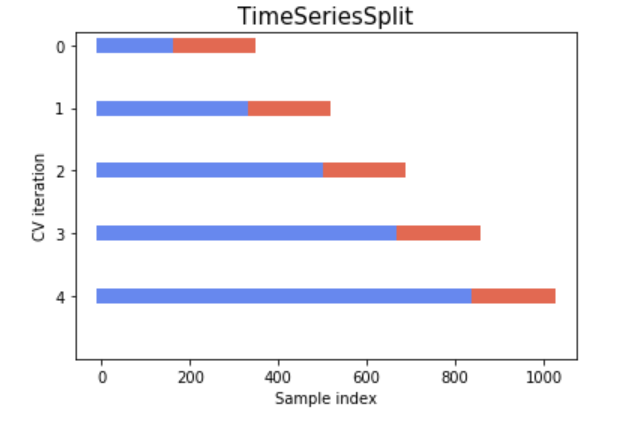


Our prediction is for one single month, so validation should be the same. I think it will be better to plan splits manually (as it follows)

In [ ]:
#I won't be using month 34 as it is test data.
#I'll focus cv on start of first year
tscv = {
    'cv1' : [12, 17],
    'cv2' : [22, 23],
    'cv3' : [28, 29],
    'cv3' : [32, 33]
}

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=150)
    
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

# **Training Model**

In [ ]:
#Saving optimized params
opt_params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}

for key, value in trial.params.items():
        opt_params[key] = [value]

In [ ]:
# Training data with best parameters but higher interactions
data, target = dataset.drop('item_cnt_month', axis=1), dataset['item_cnt_month']

train_mask = data['date_block_num'] <= 32
valid_mask = data['date_block_num'] == 33

train_x, valid_x = data[train_mask], data[valid_mask]
train_y, valid_y = target[train_mask], target[valid_mask]

train_data = lgb.Dataset(train_x, label = train_y)
valid_data = lgb.Dataset(valid_x, label = valid_y)


m_lgb = lgb.train(opt_params, train_data, valid_sets = [valid_data, train_data], early_stopping_rounds = 50, verbose_eval = 20, categorical_feature = cat_features) 

In [ ]:
lgb.plot_importance(m_lgb, figsize = (10,14))

In [ ]:
y_test = dataset[dataset['date_block_num'] == 34]

preds = m_lgb.predict(y_test.drop('item_cnt_month', axis = 1)) #this is our leaderboard input

preds = preds.clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": preds
})

submission = submission.sort_values(by = ['ID'])
submission.head()

In [ ]:
submission.to_csv('lgbm_submission.csv', index=False)